<a href="https://colab.research.google.com/github/vocaltrainer/pipeline_woo/blob/main/woo_pipeline(%EC%A0%95%ED%98%95).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")
import warnings
warnings.filterwarnings('ignore') #버전문제로 출력시 에러가뜨는것을 막음
%matplotlib inline

In [ ]:
import seaborn as sns
data = sns.load_dataset('titanic')
data.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


# 1.EDA(정형)

## 1) null 값 확인

In [ ]:
print(data.shape)
data.isnull().sum()

(891, 15)


survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

age는 채우고 deck는 drop하자

무작정 drop하지말고, 다른 특성으로 grouping한 후, 각 그룹의 평균을 null대신 입력하는 식도 고려

## 2) label별 데이터 분포

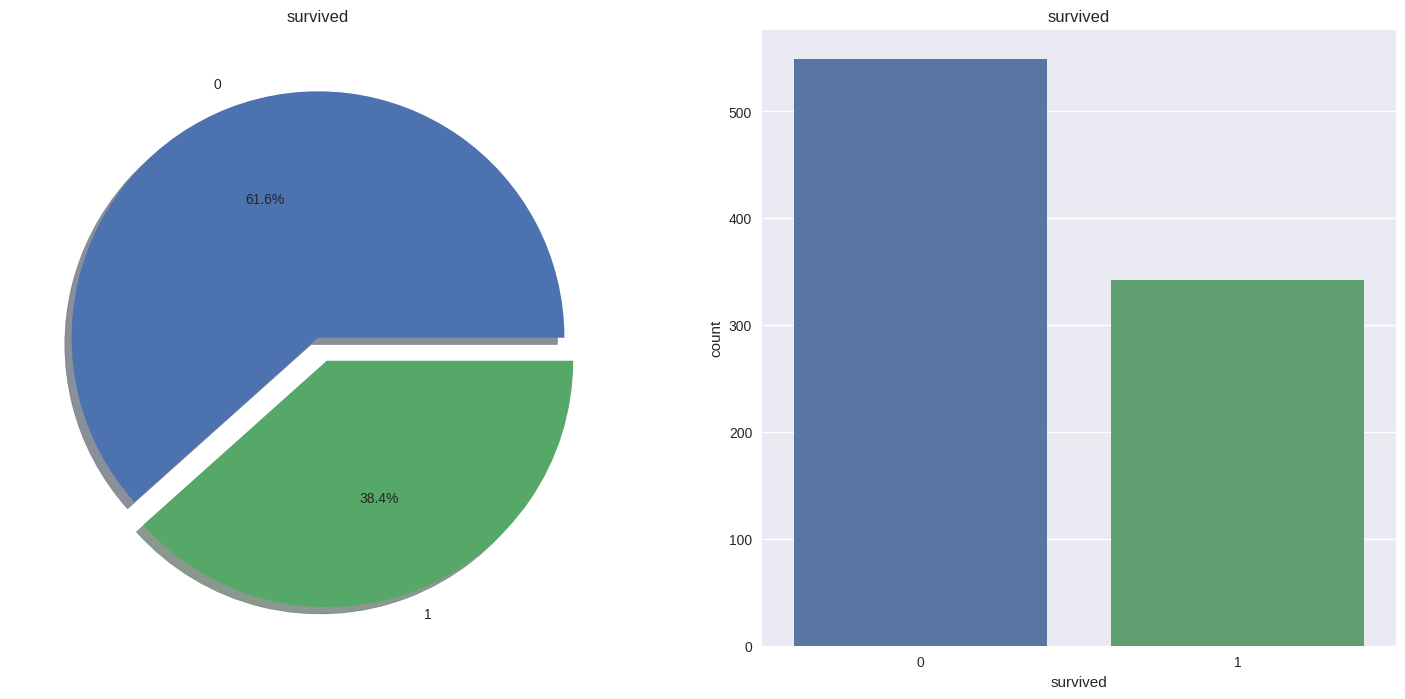

In [ ]:
import matplotlib.pyplot as plt
f,ax = plt.subplots(1,2,figsize=(18,8))
data['survived'].value_counts().plot.pie(explode=[0,0.1],
    autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('survived')
ax[0].set_ylabel('')
sns.countplot(x='survived',data=data,ax=ax[1])
ax[1].set_title('survived')
plt.show()

## 3) Categorical Feature

원핫인코딩등 사용, 무지성 인코딩 x

### crosstab

In [ ]:
pd.crosstab(data.sex,data.survived,margins=True).style.background_gradient(cmap='summer_r')

survived,0,1,All
sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


In [ ]:
pd.crosstab([data.embarked,data.pclass],
            [data.sex,data.survived],margins=True).style.background_gradient(cmap='summer_r')

### 변수 2개(categorical, categorical): sns.countplot

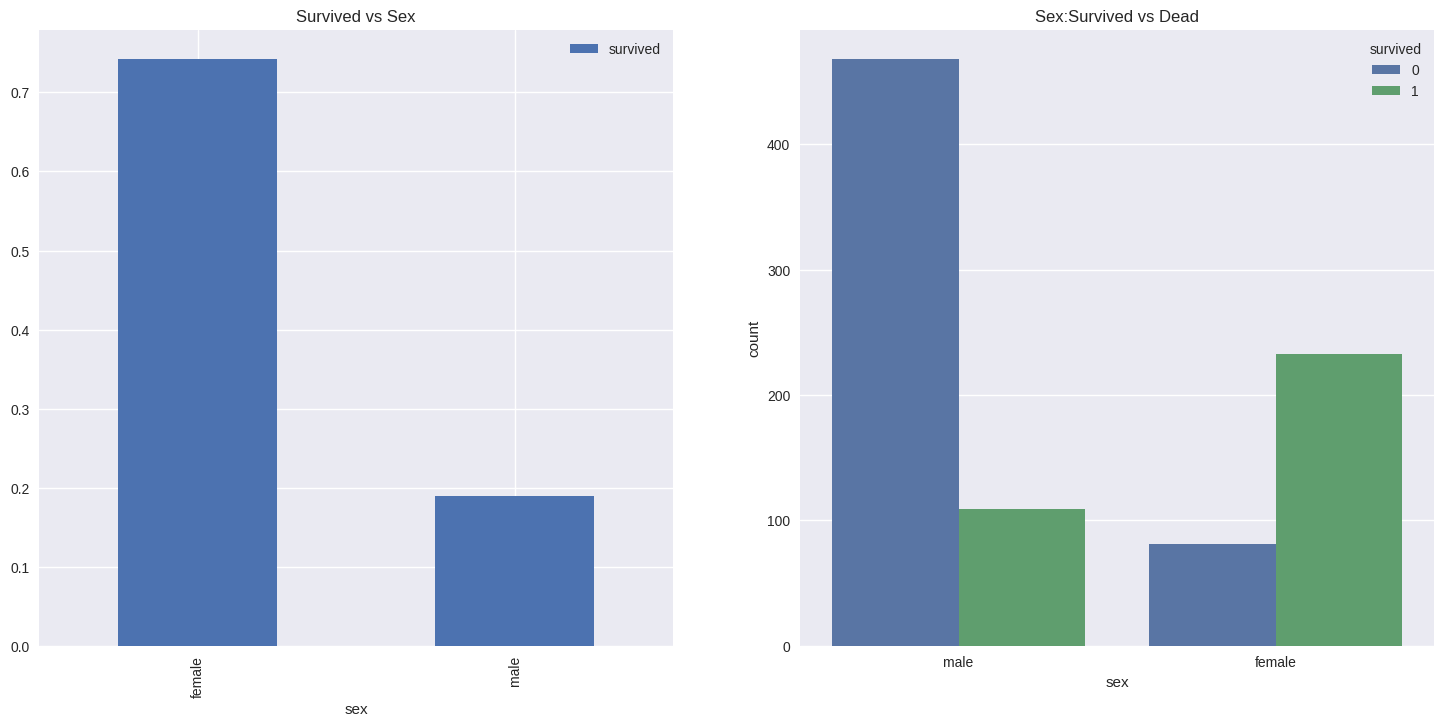

In [ ]:
f,ax=plt.subplots(1,2,figsize=(18,8))
data[['sex','survived']].groupby(['sex']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Survived vs Sex')
sns.countplot(x='sex',hue='survived',data=data,ax=ax[1])
ax[1].set_title('Sex:Survived vs Dead')
plt.show()

## 4) Ordinal Feature

Ordinal Feature(Pclass) : 1,2,3으로 순서가있는 인코딩 가능

### crosstab

In [ ]:
pd.crosstab(data.pclass,data.survived,margins=True).style.background_gradient(cmap='summer_r')

survived,0,1,All
pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


### 변수 3개(Ordinal,categorical, categorical): sns.pointplot

<Axes: xlabel='pclass', ylabel='survived'>

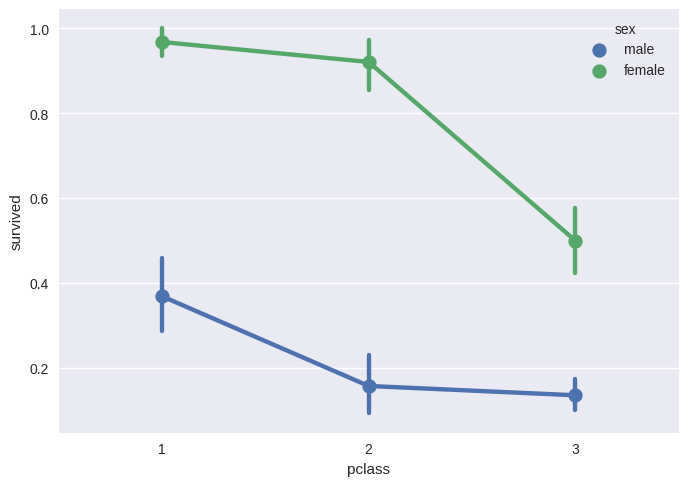

In [ ]:
sns.pointplot(x='pclass',y='survived',hue='sex',data=data)

## 5) Continous Feature

사용하는 알고리즘에 따라 Group으로 나누어 Ordinal Feature로 변경할수도있음

최대와 최소를 확인해 outlier 유무체크

mean을 확인해 데이터분포 체크

In [ ]:
print('Oldest Passenger was of:{} Years'.format(data['age'].max()))
print('Youngest Passenger was of:{} Years'.format(data['age'].min()))
print('Average Passenger was of:{:.2f} Years'.format(data['age'].mean()))

Oldest Passenger was of:80.0 Years
Youngest Passenger was of:0.42 Years
Average Passenger was of:29.70 Years


### 변수 3개(Continous, categorical, categorical): violinplot

<Axes: xlabel='pclass', ylabel='age'>

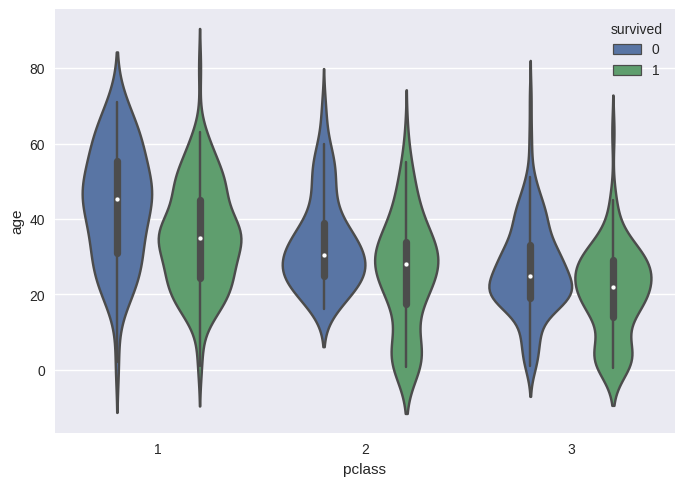

In [ ]:
sns.violinplot(x='pclass',y='age',hue='survived',data=data)

# 2.Feature Engineering, Data clean

성능향상이 보장된것은 아님!

### 1) Continous feature -> categorical feature

In [ ]:
data['Age_band'] = 0
data.loc[(data['age']<=16),'Age_band']=0
data.loc[(data['age']>16) & (data['age']<=32), 'Age_band']=1
data.loc[(data['age']>32) & (data['age']<=48), 'Age_band']=2
data.loc[(data['age']>48) & (data['age']<=64), 'Age_band']=3
data.loc[(data['age']>64) & (data['age']<=80), 'Age_band']=4

## 2) 2 feature -> 1feature

In [ ]:
data['Family_Size']=0
data['Family_Size']=data['parch']+data['SibSp']
data['Alone']=0
data.loc[data['Family_Size']==0,'Alone']=1

## 3) Continous feature -> ordinal feature

qcut은 입력한 구간의 수에 따라 데이터 수를 균일하게 분할

ex) 'Fare'는 불균형하게 분포되어있는데, 이를 4개의 구간으로 나눔

In [ ]:
data['Fare_Range'] = pd.qcut(data['Fare'],4)
data.groupby(['Fare_Range'])['Survived'].mean().to_frame().style.background_gradient('summer_r')

In [ ]:
data['Fare_cat']=0
data.loc[data['Fare'] <= 7.91, 'Fare_cat'] = 0
data.loc[(data['Fare'] > 7.91) & (data['Fare']<=14.454), 'Fare_cat'] = 1
data.loc[(data['Fare'] > 14.454) & (data['Fare']<=31), 'Fare_cat'] = 2
data.loc[(data['Fare'] > 31) & (data['Fare']<=513), 'Fare_cat'] = 3

## 4) String -> Numeric

In [ ]:
data['Sex'].replace(['male','female'],[0,1],inplace=True)
data['Embarked'].replace(['S','C','Q'],[0,1,2],inplace=True)
data['Initial'].replace(['Mr','Mrs','Miss','Master','Other'],[0,1,2,3,4],inplace=True)

## 5) Feature clean

In [ ]:
data.drop(['Name','Age','Ticket','Fare','Cabin','Fare_Range','PassengerId'],axis=1,inplace=True)
sns.heatmap(data.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':20})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

HeatMap 해석:
두 feature가 상당히 높은 상관관계를 가지고 있다면, 둘다 사용할 필요가 없음. 이런 feature는 제거해야함.

불필요한 특징들을 제거하고보니, 상관관계가 있는 feature들이 보이기 시작(0.5까지는 봐줄만 함)

# 3.Predicgtive Modeling

In [ ]:
from sklearn.linear_model import LogisticRegression #logistic regression
from sklearn import svm #support vector Machine
from sklearn.ensemble import RandomForestClassifier #Random Forest
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #Naive bayes
from sklearn.tree import DecisionTreeClassifier #Decision Tree
from sklearn.model_selection import train_test_split #training and testing data split
from sklearn import metrics #accuracy measure
from sklearn.metrics import confusion_matrix #for confusion matrix

stratify : split시 train과 test의 data['Survived']비율을 비슷하게 함.

In [ ]:
train,test=train_test_split(data,test_size=0.3,random_state=0,stratify=data['Survived'])
train_X=train[train.columns[1:]]
train_Y=train[train.columns[:1]]
test_X=test[test.columns[1:]]
test_Y=test[test.columns[:1]]
X=data[data.columns[1:]]
Y=data['Survived']

## 1) Radial Support Vedctor Machines

In [ ]:
model = svm.SVC(kernel='rbf',C=1,gamma=0.1)
model.fit(train_X,train_Y)
prediction1=model.predict(test_X)
print('Accuracy for rbf SVM is',metrics.accuracy_score(prediction1,test_Y))

## 2) Logistic Regression

In [ ]:
model = LogisticRegression()
model.fit(train_X,train_Y)
prediction3=model.predict(test_X)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,test_Y))

## 3) Decision Tree

In [ ]:
model=DecisionTreeClassifier()
model.fit(train_X,train_Y)
prediction4=model.predict(test_X)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(prediction4,test_Y))

## 4) K-Nearest Neighbours

In [ ]:
model=KNeighborsClassifier()
model.fit(train_X,train_Y)
prediction5=model.predict(test_X)
print('The accuracy of the KNN is',metrics.accuracy_score(prediction5,test_Y))

### 파라미터 설정

In [ ]:
a_index=list(range(1,11))
a=[0,0,0,0,0,0,0,0,0,0]
x=[0,1,2,3,4,5,6,7,8,9,10]
for i in list(range(1,11)):
    model=KNeighborsClassifier(n_neighbors=i)
    model.fit(train_X,train_Y)
    prediction=model.predict(test_X)
    a[i-1]=metrics.accuracy_score(prediction,test_Y)
plt.plot(a_index, a)
plt.xticks(x)
fig=plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a,'with the max value as '
      ,max(a))

## 5) Gaussian Naive bayes

In [ ]:
model=GaussianNB()
model.fit(train_X,train_Y)
prediction6=model.predict(test_X)
print('The accuracy of the NaiveBayes is',metrics.accuracy_score(prediction6,test_Y))

## 6) Random Forests

In [ ]:
model=RandomForestClassifier(n_estimators=100)
model.fit(train_X,train_Y)
prediction7=model.predict(test_X)
print('The accuracy of the Random Forests is',metrics.accuracy_score(prediction7,test_Y))

## 7) 각 모델별 Cross Validation 적용 후 비교

데이터의 불균형, 일반화된 모델을 만들기위해 사용

In [ ]:
from sklearn.model_selection import KFold #for K-fold cross validation
from sklearn.model_selection import cross_val_score #score evaluation
from sklearn.model_selection import cross_val_predict #prediction
kfold = KFold(n_splits=10) # k=10, split the data into 10 equal parts
xyz=[]
accuracy=[]
std=[]
classifiers=['Linear Svm','Radial Svm','Logistic Regression','KNN','Decision Tree',
             'Naive Bayes','Random Forest']
models=[svm.SVC(kernel='linear'),svm.SVC(kernel='rbf'),LogisticRegression(),
        KNeighborsClassifier(n_neighbors=9),DecisionTreeClassifier(),GaussianNB(),
        RandomForestClassifier(n_estimators=100)]
for i in models:
    model = i
    cv_result = cross_val_score(model,X,Y, cv = kfold,scoring = "accuracy")
    cv_result=cv_result
    xyz.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
new_models_dataframe2=pd.DataFrame({'CV Mean':xyz,'Std':std},index=classifiers)
new_models_dataframe2

## 8) 상위 2개 모델 하이퍼파라미터 튜닝

SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
C=[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear']
hyper={'kernel' : kernel, 'C' : C, 'gamma' : gamma}
gd=GridSearchCV(estimator=svm.SVC(), param_grid=hyper, verbose=True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

Random Forests

In [ ]:
n_estimators = range(100, 1000, 100)
hyper = { 'n_estimators' : n_estimators }
gd = GridSearchCV(estimator=RandomForestClassifier(random_state=0), param_grid=hyper, verbose = True)
gd.fit(X,Y)
print(gd.best_score_)
print(gd.best_estimator_)

## 9) AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=200, random_state = 0, learning_rate = 0.1)
result = cross_val_score(ada, X, Y, cv=10, scoring = 'accuracy')
print('The cross validated score for AdaBoost is: ', result.mean())

## 10) XGBoost

In [ ]:
import xgboost as xg
xgboost = xg.XGBClassifier(n_estimators=900, learning_rate = 0.1)
result = cross_val_score(xgboost, X, Y, cv=10, scoring='accuracy')
print('The cross validated score for XGBoost is: ', result.mean())

## 11) Confusion Matrix for best Model

In [ ]:
ada = AdaBoostClassifier(n_estimators=100, random_state=0,learning_rate = 0.1)
result = cross_val_predict(ada, X, Y, cv=10)
sns.heatmap(confusion_matrix(Y, result), cmap='winter', annot=True, fmt = '2.0f')
plt.show()

## 12) Feature Importance

In [ ]:
f,ax=plt.subplots(2,2,figsize=(15,12))

model=RandomForestClassifier(n_estimators=500,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,0])
ax[0,0].set_title('Feature Importance in Random Forests')

model=AdaBoostClassifier(n_estimators=200,learning_rate=0.05,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[0,1],color='#ddff11')
ax[0,1].set_title('Feature Importance in AdaBoost')

model=GradientBoostingClassifier(n_estimators=500,learning_rate=0.1,random_state=0)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,0],cmap='RdYlGn_r')
ax[1,0].set_title('Feature Importance in Gradient Boosting')

model=xg.XGBClassifier(n_estimators=900, learning_rate=0.1)
model.fit(X,Y)
pd.Series(model.feature_importances_,X.columns).sort_values(ascending=True).plot.barh(width=0.8,ax=ax[1,1],color='#FD0F00')
ax[1,1].set_title('Feature Importance in XgBoost')

plt.show()